In [1]:
import torch
from torch import optim
from dataset import ImageDataLoadBuilder, visualize_example
from models import ConvNet
from torch import nn
from torch_snippets.torch_loader import Report
from torchsummary import summary
from torchvision import transforms

In [2]:
gpu = torch.cuda.is_available()

device = torch.device(0) if gpu else torch.device("cpu")

In [3]:
width       = 224
height      = 224
nchannels   = 3
input_size = (height,width)
input_shape = (nchannels,height,width)
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

In [4]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [5]:
builder = ImageDataLoadBuilder(
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

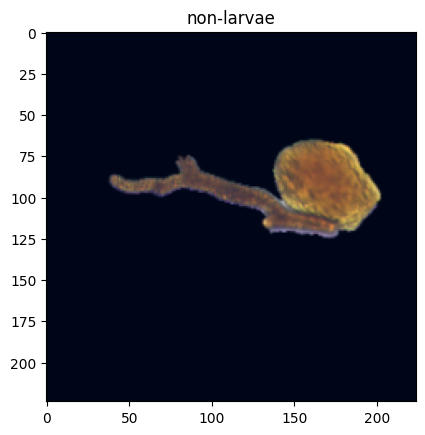

In [6]:
visualize_example(train_loader.dataset)

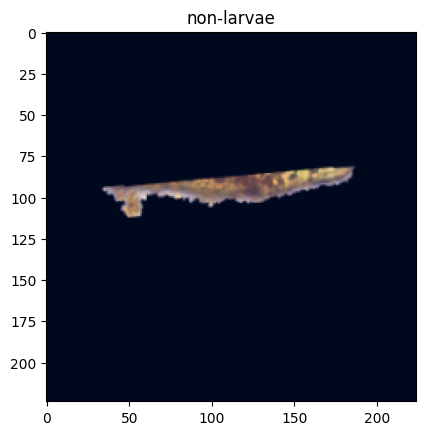

In [7]:
visualize_example(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(799, 319, 480)

In [9]:
nclasses = 2
model = ConvNet(input_shape, nclasses).to(device)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
            Conv2d-4          [-1, 8, 224, 224]             576
       BatchNorm2d-5          [-1, 8, 224, 224]              16
              ReLU-6          [-1, 8, 224, 224]               0
         MaxPool2d-7          [-1, 8, 112, 112]               0
            Conv2d-8         [-1, 16, 112, 112]           1,152
       BatchNorm2d-9         [-1, 16, 112, 112]              32
             ReLU-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 16, 112, 112]           2,304
      BatchNorm2d-12         [-1, 16, 112, 112]              32
             ReLU-13         [-1, 16, 112, 112]               0
        MaxPool2d-14           [-1, 16,

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [11]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

In [12]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

In [13]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

In [14]:
# initializing variables
n_epochs = 80
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(train_loader)
    for bx, data in enumerate(train_loader):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(valid_loader)
    for bx, data in enumerate(valid_loader):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0:
        log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

EPOCH: 10.000  trn_acc: 0.565  val_loss: 0.695  trn_loss: 0.699  val_acc: 0.599  (186.79s - 1307.55s remaining)
EPOCH: 20.000  trn_acc: 0.790  val_loss: 0.550  trn_loss: 0.576  val_acc: 0.837  (389.41s - 1168.24s remaining)
EPOCH: 30.000  trn_acc: 0.831  val_loss: 0.495  trn_loss: 0.520  val_acc: 0.871  (583.55s - 972.58s remaining)
EPOCH: 40.000  trn_acc: 0.825  val_loss: 0.496  trn_loss: 0.518  val_acc: 0.862  (825.01s - 825.01s remaining)
EPOCH: 50.000  trn_acc: 0.820  val_loss: 0.470  trn_loss: 0.514  val_acc: 0.884  (1097.21s - 658.33s remaining)
EPOCH: 60.000  trn_acc: 0.829  val_loss: 0.470  trn_loss: 0.510  val_acc: 0.884  (1366.42s - 455.47s remaining)
EPOCH: 70.000  trn_acc: 0.827  val_loss: 0.483  trn_loss: 0.513  val_acc: 0.868  (1661.37s - 237.34s remaining)
EPOCH: 80.000  trn_acc: 0.830  val_loss: 0.471  trn_loss: 0.520  val_acc: 0.881  (1955.60s - 0.00s remaining)


100%|██████████| 181/181 [00:00<00:00, 3694.18it/s]


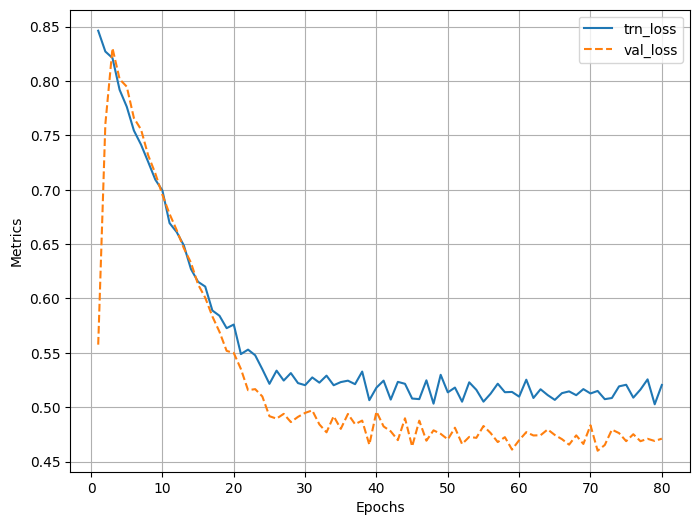

100%|██████████| 181/181 [00:00<00:00, 2267.21it/s]


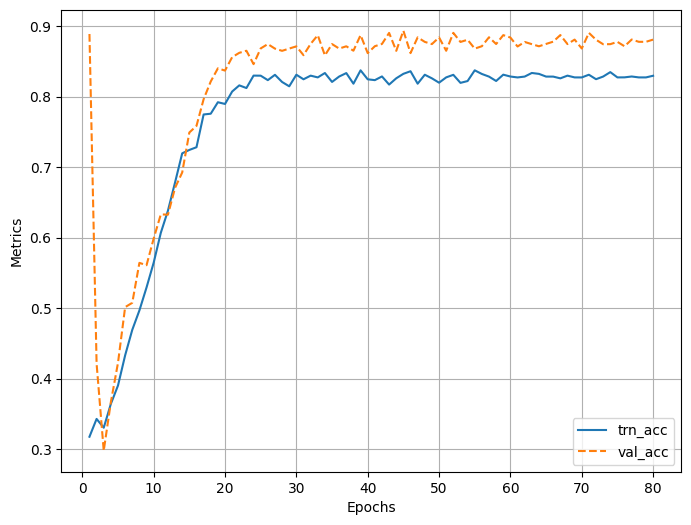

In [15]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

In [16]:
def test(model, test_loader, criterion, device):
    N = len(test_loader)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(test_loader):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = test(model, test_loader, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.520832 Acc: 0.833333


In [18]:
model_name = "weights/CNN.pth"
torch.save(model.to('cpu').state_dict(), model_name)